In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt
from PIL import Image

import os
from tqdm import tqdm
from glob import glob

from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms as transforms


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       print(os.path.join(dirname, filename))
      
        


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163029_cell_57.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_cell_63.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_162922_cell_205.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_cell_144.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_cell_159.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_cell_34.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163047_cell_22.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163047_cell_36.png
/kaggle/input/malaria-detection-dataset/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_c

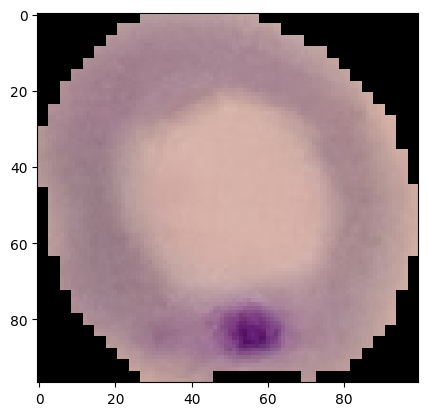

In [2]:
data_path = "/kaggle/input/malaria-detection-dataset/Dataset/"
type_path = ["Train/", "Test/"]
folder = ['Parasite', 'Uninfected']

# データの確認
file0 = glob(data_path + type_path[0] + folder[0] + "/*.png")[0]
image = Image.open(file0)
plt.imshow(image) 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.
print(f"Using {device} device")

Using cuda device


In [4]:
image_size = 128;

In [5]:
X = [];
y = [];
usenumber = 1000
folder = ['Parasite', 'Uninfected']

for i,folname in enumerate(folder):
    files1 = glob(data_path + type_path[0] + folname + "/*.png"); #フォルダ内のファイル名を取得
    f_number = len(files1) #randomに一部のデータのみ抽出するためのコード
    files1, files2=torch.utils.data.random_split(files1,[usenumber,f_number - usenumber])
    for j, file in enumerate(tqdm(files1)):
        outcome = i
        image = Image.open(file) # 画像ファイルの読み込み
        image = image.convert("RGB") # RGBモードに変換
        image = image.resize((image_size, image_size)) # リサイズ
        data = np.asarray(image) # 画像を配列に変換
        X.append(data); # 複数枚を１つの配列に保存
        y.append(outcome)  #正解ラベルをyとして保存

100%|██████████| 196/196 [00:01<00:00, 182.64it/s]


In [6]:
#配列データへの変換 ４次元のデータとして(画像枚数，RGBの層，画像の高さ，画像の横幅)になるように次元を入れ替え
X = np.array(X).astype(np.float32).transpose(0,3,1,2)/255
y = np.array(y)

In [7]:
Nall = X.shape[0]

In [8]:
tensor_X = torch.tensor(X, dtype=torch.float32) #Tensor型として変換
tensor_y = torch.tensor(y, dtype=torch.int64) #Tensor型として変換

In [9]:
dataset = torch.utils.data.TensorDataset(tensor_X,tensor_y)# 目的変数と入力変数をまとめてdatasetに変換
n_train = int(Nall * 0.7) # Training データ数
n_val = int(Nall * 0.2)   # Validation データ数
n_test = Nall - n_train - n_val # Test データ数
train_x, val_x, test_x = torch.utils.data.random_split(dataset, [n_train, n_val,n_test]) # データセットの分割
print("train =",n_train,",validation =",n_val,",Test =",n_test)

train = 291 ,validation = 83 ,Test = 42


In [10]:
batch_size = 64 #バッチサイズの指定
train_dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)  # data loaderとして指定
val_dataloader   = DataLoader(val_x,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_x,  batch_size=1, shuffle=False)

In [11]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3,128,128),output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [12]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=[-7.5, 7.5])
    ]
) #Data augumentation

In [13]:
#最適化
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.005)

def train(train_loader): #Training
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #data augumentation
        #images = transform(images)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def valid(test_loader): #Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

#空の配列
acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []

In [14]:
nepoch = 300

#Fitting
for epoch in range(nepoch):
    loss, acc = train(train_dataloader)
    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6945 acc: 0.4639 val_loss: 0.6958 val_acc: 0.4096
epoch 1, loss: 0.6953 acc: 0.4639 val_loss: 0.6945 val_acc: 0.4096
epoch 2, loss: 0.6927 acc: 0.5189 val_loss: 0.6929 val_acc: 0.5663
epoch 3, loss: 0.6924 acc: 0.5223 val_loss: 0.6913 val_acc: 0.5904
epoch 4, loss: 0.6914 acc: 0.5395 val_loss: 0.6900 val_acc: 0.5904
epoch 5, loss: 0.6916 acc: 0.5361 val_loss: 0.6890 val_acc: 0.5904
epoch 6, loss: 0.6911 acc: 0.5361 val_loss: 0.6881 val_acc: 0.5904
epoch 7, loss: 0.6898 acc: 0.5361 val_loss: 0.6876 val_acc: 0.5904
epoch 8, loss: 0.6900 acc: 0.5361 val_loss: 0.6873 val_acc: 0.5904
epoch 9, loss: 0.6906 acc: 0.5361 val_loss: 0.6869 val_acc: 0.5904
epoch 10, loss: 0.6916 acc: 0.5361 val_loss: 0.6866 val_acc: 0.5904
epoch 11, loss: 0.6902 acc: 0.5361 val_loss: 0.6864 val_acc: 0.5904
epoch 12, loss: 0.6903 acc: 0.5361 val_loss: 0.6864 val_acc: 0.5904
epoch 13, loss: 0.6906 acc: 0.5361 val_loss: 0.6864 val_acc: 0.5904
epoch 14, loss: 0.6907 acc: 0.5361 val_loss: 0.6864 val_ac

正解率： 91.56626506024097 %


Text(0, 0.5, 'acc')

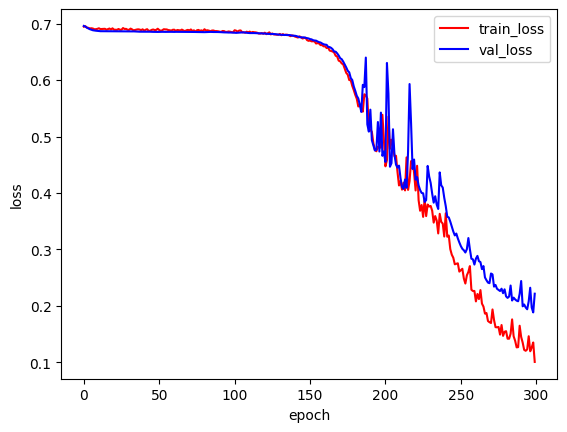

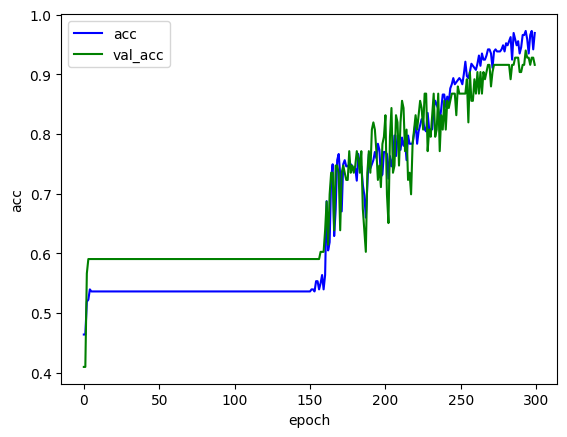

In [15]:
print('正解率：',val_acc_list[-1]*100, '%')

#学習過程の表示
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')